In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

<h1 style="color:blue;">Listings information gathering</h1>


In [20]:
listings = pd.read_csv('listings.csv')

<h4 style="color:brown;">We shuffle the dataset beforehand to avoid any patttern while performing analysis and preprocessing</h4>


In [21]:
listings = listings.sample(frac=1).reset_index(drop=True)

In [22]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86064 entries, 0 to 86063
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              86064 non-null  int64  
 1   name                            86064 non-null  object 
 2   host_id                         86064 non-null  int64  
 3   host_name                       86023 non-null  object 
 4   neighbourhood_group             0 non-null      float64
 5   neighbourhood                   86064 non-null  object 
 6   latitude                        86064 non-null  float64
 7   longitude                       86064 non-null  float64
 8   room_type                       86064 non-null  object 
 9   price                           55655 non-null  float64
 10  minimum_nights                  86064 non-null  int64  
 11  number_of_reviews               86064 non-null  int64  
 12  last_review                     

In [23]:
listings.isnull().sum()

id                                    0
name                                  0
host_id                               0
host_name                            41
neighbourhood_group               86064
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                             30409
minimum_nights                        0
number_of_reviews                     0
last_review                       21794
reviews_per_month                 21794
calculated_host_listings_count        0
availability_365                      0
number_of_reviews_ltm                 0
license                           18018
dtype: int64

Text(0, 0.5, 'Columns')

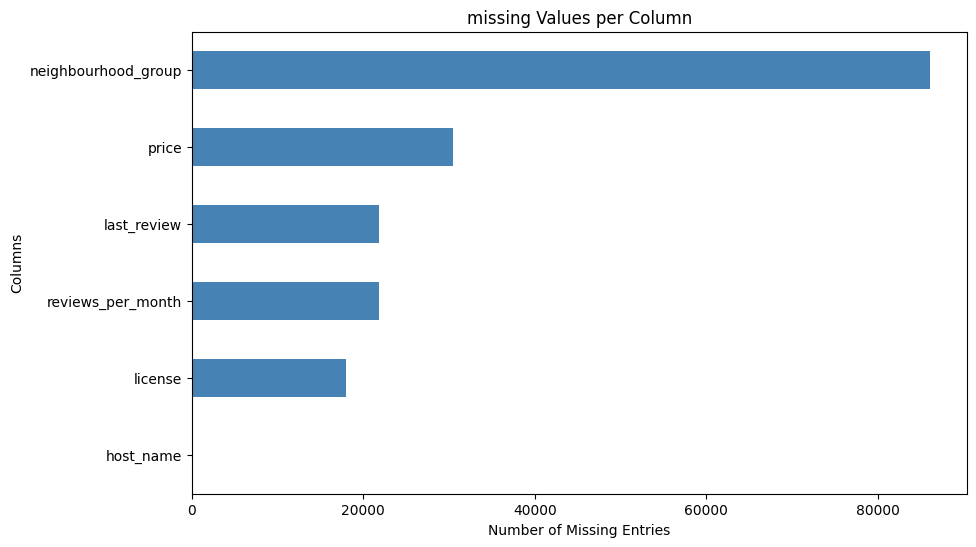

In [24]:
null_counts = listings.isnull().sum()

null_counts = null_counts[null_counts > 0].sort_values()
plt.figure(figsize=(10, 6))
null_counts.plot(kind='barh', color='steelblue')
plt.title("missing Values per Column")
plt.xlabel("Number of Missing Entries")
plt.ylabel("Columns")

In [25]:
listings.isnull().sum().sum()

np.int64(178120)

### First we have to inspect the calendar.csv file to understand whether listings change their nightly price over time (dynamic pricing) or keep a single fixed price. The results will determine whether we must preserve daily seasonality in our ML dataset or can safely collapse calendar data per listing.

In [26]:
calendar = pd.read_csv('calendar.csv')

C:\Users\othma\AppData\Local\Temp\ipykernel_14420\1057505667.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  calendar = pd.read_csv('calendar.csv')


In [27]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31442697 entries, 0 to 31442696
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   listing_id      int64  
 1   date            object 
 2   available       object 
 3   price           object 
 4   adjusted_price  object 
 5   minimum_nights  float64
 6   maximum_nights  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 1.6+ GB


In [28]:
calendar.available.value_counts()

available
f    20302441
t    11140256
Name: count, dtype: int64

### Now we should remove currency symbols and thousands separators, then casts price to float so that the price column becomes numeric and can be summarized/aggregated.

In [29]:
# Remove $ and commas then we converted to float
calendar['price'] = calendar['price'].replace('[\$,]', '', regex=True).astype(float)

calendar['price'].head()

0    100.0
1    100.0
2    100.0
3    100.0
4    100.0
Name: price, dtype: float64

### Here we did determine whether each listing uses a single fixed price or multiple prices across days. what we did is group calendar rows by listing_id and compute .nunique() of price. Then compute counts and percentage of listings with >1 unique price. so that we can get how many unique values price have for each listings_id

In [30]:
unique_prices = calendar.groupby("listing_id")["price"].nunique()

dynamic_count = (unique_prices > 1).sum()
static_count = (unique_prices == 1).sum()
dynamic_percentage = (unique_prices > 1).mean() * 100

print("Dynamic listings (more than 1 price):", dynamic_count)
print("Static listings (1 price):", static_count)
print("Dynamic percentage (%):", dynamic_percentage)

Dynamic listings (more than 1 price): 175
Static listings (1 price): 85887
Dynamic percentage (%): 0.20334177685854385


### we can see from the result above that only 175 listings changed their price over the year. which represents only 0.2% of our data which is almost irrelevent and won't add any feature attribute to our model

### What we can do is since seasonality is basically nonexistent we can use the mean price value for each listings of the calendar in the listings 

In [31]:
calendar_prices = calendar.groupby("listing_id")["price"].mean()

In [32]:
listings = listings.merge(calendar_prices, left_on="id", right_index=True, suffixes=("", "_calendar"))

In [33]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86062 entries, 0 to 86063
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              86062 non-null  int64  
 1   name                            86062 non-null  object 
 2   host_id                         86062 non-null  int64  
 3   host_name                       86021 non-null  object 
 4   neighbourhood_group             0 non-null      float64
 5   neighbourhood                   86062 non-null  object 
 6   latitude                        86062 non-null  float64
 7   longitude                       86062 non-null  float64
 8   room_type                       86062 non-null  object 
 9   price                           55655 non-null  float64
 10  minimum_nights                  86062 non-null  int64  
 11  number_of_reviews               86062 non-null  int64  
 12  last_review                     64268

<h4 style="color:orange;">Before moving to null values handling lets discover our dataset</h4>



<h6 style="color:pink;">We can see from the graph below that most of the room types are Entire home/apt with some small number of Private rooms</h4>


C:\Users\othma\AppData\Local\Temp\ipykernel_14420\3292264052.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x = 'room_type', data = listings, palette = 'viridis')


Text(0.5, 1.0, 'Distribution of Room Types')

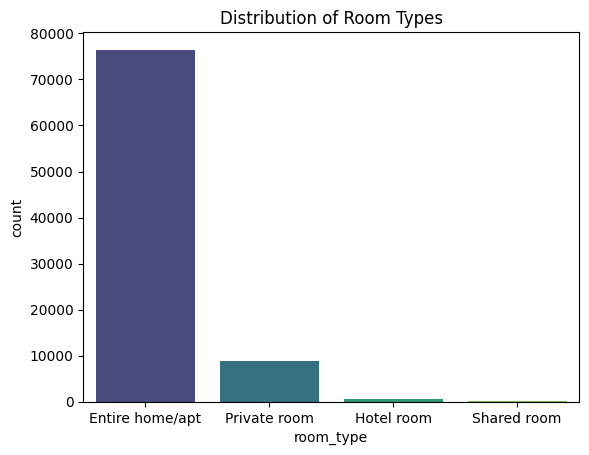

In [34]:
ax = sns.countplot(x = 'room_type', data = listings, palette = 'viridis')
ax.set_title('Distribution of Room Types')

This chart bellow shows the distribution of Airbnb room types across the ten neighbourhoods with the highest number of listings.
we first took the top 10 neighborhood wjo have most listings then we created a countplot that give the distribution of room types across these neighborhood

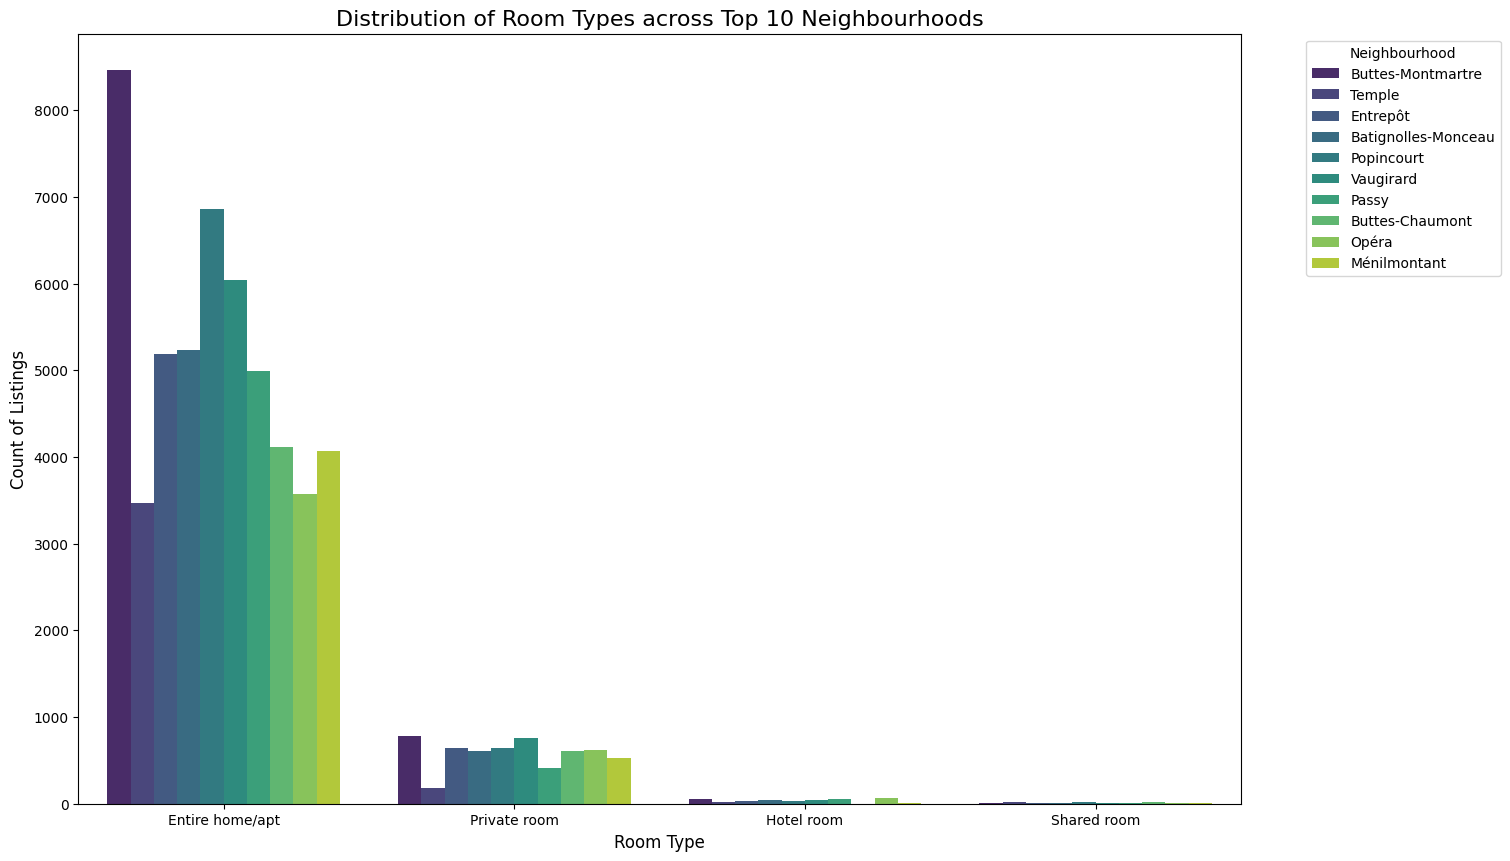

In [35]:
# we take top 10 neighborhood by how much listings they have
top_neighbourhoods = listings['neighbourhood'].value_counts().index[:10]
#then we select these listings
listings_top = listings[listings['neighbourhood'].isin(top_neighbourhoods)]
# and here we plot
plt.figure(figsize=(15, 10))
ax = sns.countplot(x='room_type', hue='neighbourhood', data=listings_top, palette='viridis')
plt.title('Distribution of Room Types across Top 10 Neighbourhoods', fontsize=16)
plt.xlabel('Room Type', fontsize=12)
plt.ylabel('Count of Listings', fontsize=12)
plt.legend(title='Neighbourhood', bbox_to_anchor=(1.05, 1), loc='upper left') # Move legend outside

The histogram below shows the distribution of listing prices. We can see that most rooms are priced below €300, which suggests that the price is concentrated in the low–to–mid price range

Text(0.5, 1.0, 'Distribution of Listings Prices')

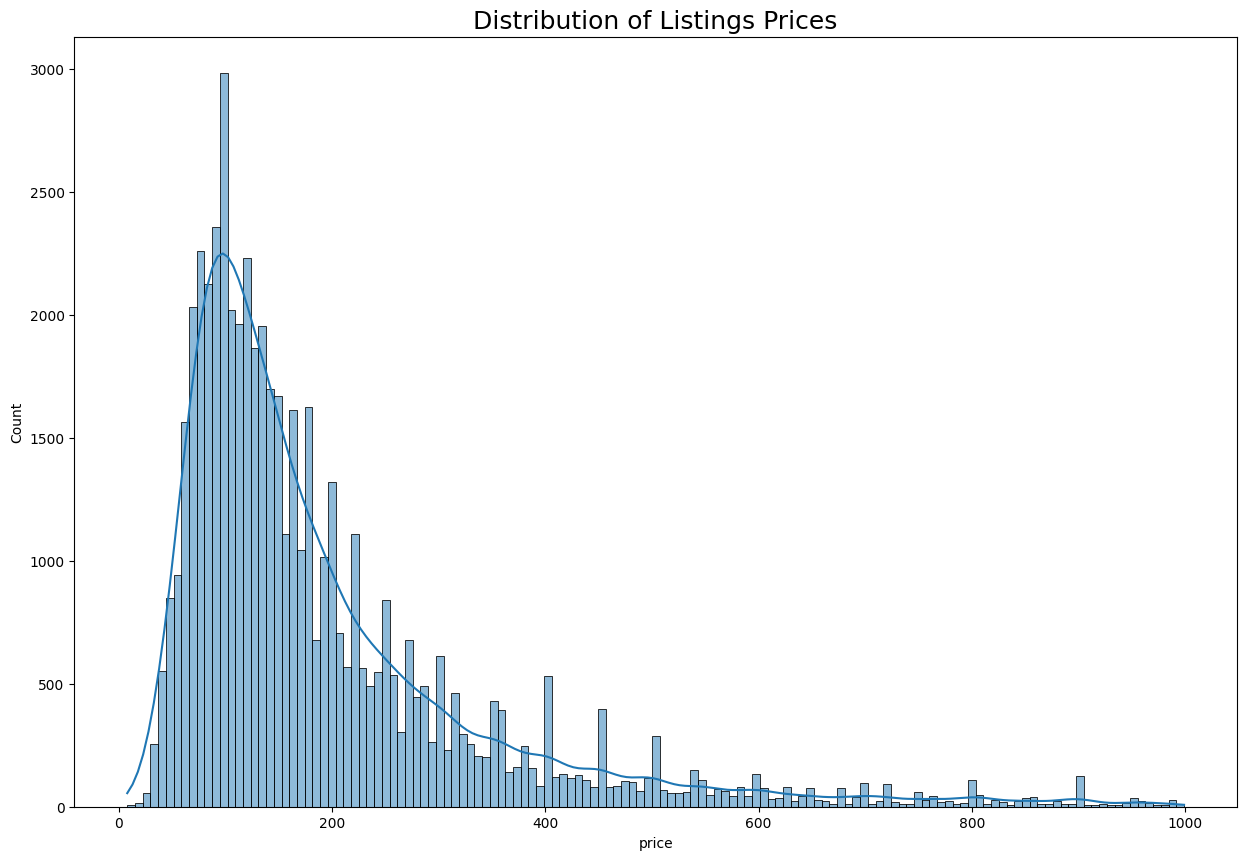

In [36]:
plt.figure(figsize=(15, 10))
k = listings[listings['price'] < 1000]  

sns.histplot(k.price, kde = True)

plt.title("Distribution of Listings Prices", fontsize=18)

<h4 style="color:orange;">1/since all entries of 'neighbourhood_group' column are set to 'NaN', we can drop the column</h4>


In [37]:
listings.isnull().sum()

id                                    0
name                                  0
host_id                               0
host_name                            41
neighbourhood_group               86062
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                             30407
minimum_nights                        0
number_of_reviews                     0
last_review                       21794
reviews_per_month                 21794
calculated_host_listings_count        0
availability_365                      0
number_of_reviews_ltm                 0
license                           18016
price_calendar                        0
dtype: int64

here we drop the column

In [38]:
listings.drop('neighbourhood_group', axis = 1, inplace = True)

In [39]:
listings.isnull().sum()

id                                    0
name                                  0
host_id                               0
host_name                            41
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                             30407
minimum_nights                        0
number_of_reviews                     0
last_review                       21794
reviews_per_month                 21794
calculated_host_listings_count        0
availability_365                      0
number_of_reviews_ltm                 0
license                           18016
price_calendar                        0
dtype: int64

<h4 style="color:orange;">2/now, for the host_name, we can see that we have 9 entries with missing host_name value.
    We can drop them</h4>


In [40]:
listings[listings['host_name'].isnull()]

,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,price_calendar
4440,1862480,St Germain - Odeon,9714622,NaN,Luxembourg,48.852900,2.339850,Entire home/apt,330.0,6,95,2024-12-23,0.71,1,196,7,7510601175502,330.0
4957,1181851656740863405,appartement 2 pièces lumineux,30471125,NaN,Reuilly,48.838428,2.393191,Entire home/apt,80.0,3,7,2025-02-16,1.34,1,6,7,7511214142256,80.0
7815,993224454810809295,Peaceful flat full of charm in le Haut Marais,20925215,NaN,Temple,48.861803,2.363057,Entire home/apt,168.0,1,11,2024-12-11,1.02,1,12,11,7510311358011,190.0
9612,19262755,Appartement spacieux lumineux et chaleureux.,134875730,NaN,Popincourt,48.862330,2.373780,Entire home/apt,NaN,365,0,NaN,NaN,1,0,0,NaN,100.0
13813,1133273024997011046,Appartement luxe - Paris 16,566697787,NaN,Passy,48.839728,2.264008,Entire home/apt,1500.0,30,0,NaN,NaN,1,0,0,"Available with a mobility lease only (""bail mo...",1500.0
17622,1049933144151935793,Chambre double privée : 2 PAX,550649151,NaN,Opéra,48.877473,2.342485,Private room,93.0,1,60,2025-02-20,4.22,7,190,48,NaN,89.0
23245,1070222164861166113,Chambre double privée standard,550649151,NaN,Opéra,48.877473,2.342485,Private room,92.0,1,19,2025-02-22,2.49,7,196,19,NaN,89.0
25203,1138355429639917552,Joli cocon parisien au cœur de la rue de Lévis,572113144,NaN,Batignolles-Monceau,48.883073,2.314999,Entire home/apt,166.0,2,2,2024-11-11,0.20,1,13,2,7511710883711,160.0
29302,1049329574812624757,Chambre quadruple : 4 PAX,550649151,NaN,Opéra,48.877473,2.342485,Private room,153.0,1,12,2024-12-22,1.03,7,177,12,NaN,149.0
29679,654829664694172347,COSY NEST in the HEART of PARIS,298289133,NaN,Popincourt,48.860220,2.382210,Entire home/apt,159.0,2,49,2024-12-30,1.50,1,308,15,7511104069626,159.0


We drop the host_name entries that are null

In [41]:
listings.dropna(subset=['host_name'],inplace=True)

In [42]:
listings.isnull().sum()

id                                    0
name                                  0
host_id                               0
host_name                             0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                             30393
minimum_nights                        0
number_of_reviews                     0
last_review                       21779
reviews_per_month                 21779
calculated_host_listings_count        0
availability_365                      0
number_of_reviews_ltm                 0
license                           18000
price_calendar                        0
dtype: int64

<h4 style="color:orange;">3/ likewise, the 'last_review' column only provides us with the date the last review was written. Better to drop this column as it will not provide us with that much information</h4>


In [43]:
listings.drop('last_review', axis = 1, inplace = True)

In [44]:
listings.isnull().sum()

id                                    0
name                                  0
host_id                               0
host_name                             0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                             30393
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 21779
calculated_host_listings_count        0
availability_365                      0
number_of_reviews_ltm                 0
license                           18000
price_calendar                        0
dtype: int64

<h4 style="color:orange;">3/ Again, since our analysis is not focused on compliance or legal verification filtering, we can drop the license column</h4>


In [45]:
listings.drop('license', axis = 1, inplace = True)

In [46]:
listings.isnull().sum()

id                                    0
name                                  0
host_id                               0
host_name                             0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                             30393
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 21779
calculated_host_listings_count        0
availability_365                      0
number_of_reviews_ltm                 0
price_calendar                        0
dtype: int64

<h4 style="color:orange;">4/ for the 'price' column, we have 30,932 null entities. The reason of the null value is maybe due to that fact that the listing is inactive </h4>


<h5 style="color:pink;">We can see that most of the null prices have an availability of 0 out of 360. This states that the listing was not available during the whole year which means the listing was inactive.</h4>


<h4 style="color:pink;">
Out of the 30,932 listings with a missing price, 27,483 have an availability_365 value of 0.  
This means they were not available for booking at all throughout the year—likely indicating inactive or removed listings.  
The remaining listings with missing price were barely available, suggesting they were either recently added or rarely active.
</h4>


In [47]:
listings[listings['price'].isnull()].head(20)

,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,price_calendar
0,860812784662157555,Appartement typique Pigalle,58990604,Georges,Buttes-Montmartre,48.884650,2.336370,Entire home/apt,NaN,3,1,0.14,1,0,1,222.0
1,6124124,NEMOZ,31775536,Isabelle,Temple,48.864110,2.358860,Entire home/apt,NaN,365,0,NaN,1,0,0,70.0
2,1133277420751404475,Charmant Triplex familial du canal de Saint Ma...,245844815,Katy Et Jérémy,Entrepôt,48.871145,2.374112,Entire home/apt,NaN,1,0,NaN,97,0,0,280.0
3,33447221,Charmant appartement XVIII ème,59564639,Julien,Buttes-Montmartre,48.892810,2.360890,Entire home/apt,NaN,365,12,0.17,1,0,0,30.0
5,19728487,奥斯曼建筑超大40 平studios,48393679,兆赫,Élysée,48.875530,2.322380,Entire home/apt,NaN,365,2,0.02,1,0,0,60.0
7,1205170463556017291,Charming studio avec cour - Paris métro Faidherbe,268511363,Albane,Popincourt,48.849902,2.386720,Entire home/apt,NaN,2,0,NaN,2,0,0,89.0
11,1133244584953689722,Studio with an incredible view!,65641646,Tarek,Vaugirard,48.848259,2.284493,Entire home/apt,NaN,1,0,NaN,1,0,0,200.0
12,42165129,Calme et cosy appt. 85 m2 à 2mn de la Tour Eiffel,334648455,Anne,Passy,48.867470,2.283620,Entire home/apt,NaN,365,0,NaN,1,0,0,139.0
14,822011,Nice & sunny apartment at Bastille,4316437,Ariane,Popincourt,48.851880,2.385710,Entire home/apt,NaN,5,14,0.09,1,0,1,220.0
15,3199889,Champs Elysées for Christas,7709874,Marouchka,Élysée,48.874100,2.306640,Entire home/apt,NaN,365,0,NaN,2,0,0,226.0


We can see that most of the null prices have an availability of 0 out of 360

In [48]:
listings[listings['price'].isnull()]['availability_365'].value_counts()

availability_365
0      26435
1        339
2        215
269      154
89       143
       ...  
350        1
315        1
248        1
259        1
328        1
Name: count, Length: 346, dtype: int64

In [49]:
availability = listings[listings['price'].isnull()]['availability_365'].value_counts().head(10)

This plot reveals how often listings are available throughout the year we can see many listings might be available for 0 days or 365 days

Text(0, 0.5, 'count')

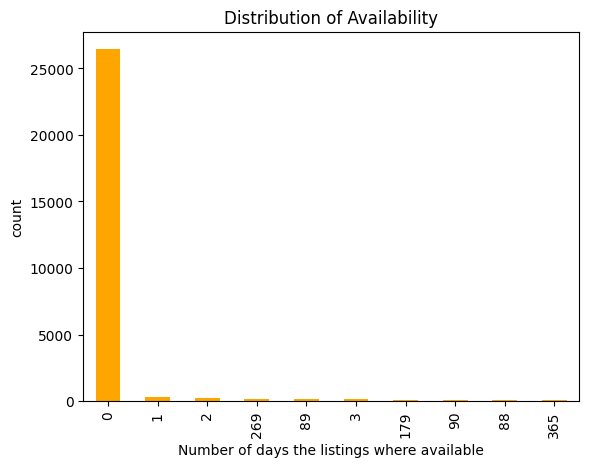

In [50]:
availability.plot(kind='bar', color='orange', title='Distribution of Availability')
plt.xlabel('Number of days the listings where available')
plt.ylabel('count')

<h4 style="color:pink;">Likewise, We can see that most of the null prices have a very low number of reviews. This comfirms that the listing was not available for people to make reviews</h4>


In [51]:
listings[listings['price'].isnull()]['number_of_reviews'].value_counts()

number_of_reviews
0      8287
1      2798
2      1938
3      1588
4      1272
       ... 
564       1
270       1
315       1
215       1
252       1
Name: count, Length: 290, dtype: int64

In [52]:
num_reviews = listings[listings['price'].isnull()]['number_of_reviews'].value_counts().head(10)

Text(0, 0.5, 'count')

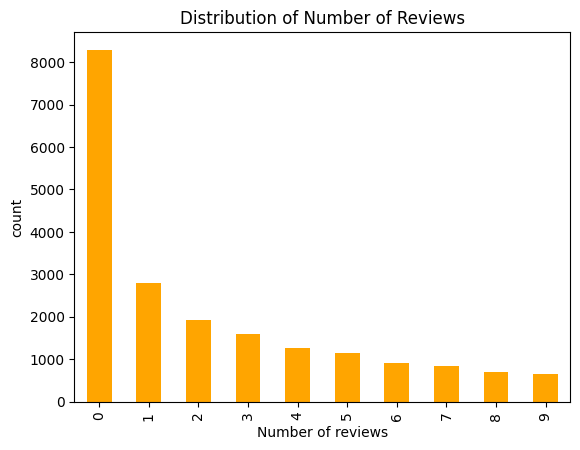

In [53]:
num_reviews.plot(kind='bar', color = 'orange', title='Distribution of Number of Reviews')
plt.xlabel('Number of reviews')
plt.ylabel('count')

<h4 style="color:pink;">The problem is that we can not drop the missing values rows from the price column because it represents nearly 35% of our data. An alternative is to impute the missing values with the median price of the same neighborhood and room_type</h4>


<h5 style="color:pink;">First, let us create a price range column inside the listings dataset. This will be helpfull for visualization and future work</h5>


C:\Users\othma\AppData\Local\Temp\ipykernel_14420\1263456015.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=price_counts.index, y=price_counts.values, palette = 'viridis')


Text(0, 0.5, 'Number of Listings')

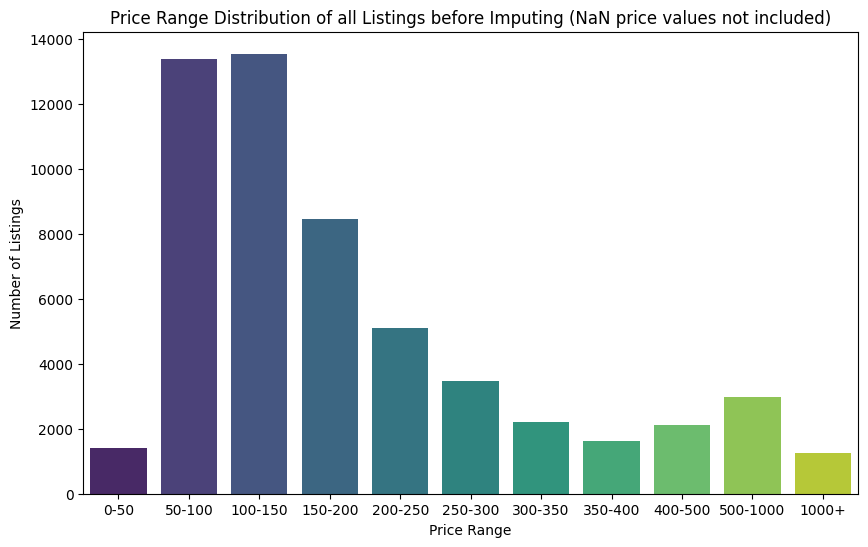

In [54]:
price_bins = [0, 50, 100, 150, 200, 250, 300, 350, 400, 500, 1000, float('inf')]
price_labels = ['0-50', '50-100', '100-150', '150-200', '200-250', '250-300', '300-350', '350-400', '400-500', '500-1000', '1000+']
listings['price_range'] = pd.cut(listings['price'], bins=price_bins, labels=price_labels, right=False)
price_counts = listings['price_range'].value_counts().sort_index()


plt.figure(figsize=(10, 6))
sns.barplot(x=price_counts.index, y=price_counts.values, palette = 'viridis')

plt.title('Price Range Distribution of all Listings before Imputing (NaN price values not included)')
plt.xlabel('Price Range')
plt.ylabel('Number of Listings')

<h5 style="color:pink;">Now, lets fill in NaN prices with the median price for that same neighborhood and room type.(using .fillna())</h5>


In [55]:
listings['price'] = listings.groupby(['neighbourhood', 'room_type'])['price'].transform(lambda x: x.fillna(x.median()))

C:\Users\othma\AppData\Roaming\Python\Python311\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [56]:
listings.isnull().sum()


id                                    0
name                                  0
host_id                               0
host_name                             0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 2
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 21779
calculated_host_listings_count        0
availability_365                      0
number_of_reviews_ltm                 0
price_calendar                        0
price_range                       30393
dtype: int64

<h4 style="color:pink;">We can see that most prices imputed are between 50 - 300</h4>


C:\Users\othma\AppData\Local\Temp\ipykernel_14420\2542513988.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=price_counts.index, y=price_counts.values, palette = 'viridis')


Text(0, 0.5, 'Number of Listings')

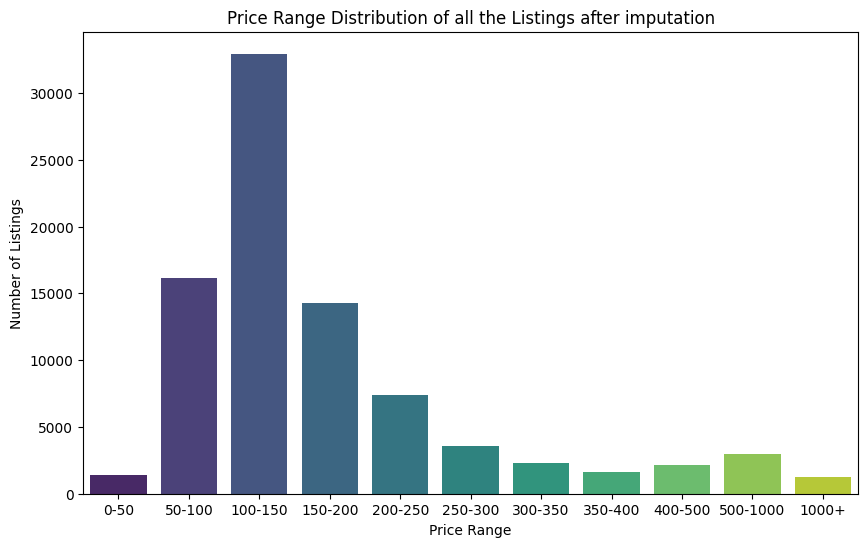

In [57]:
price_bins = [0, 50, 100, 150, 200, 250, 300, 350, 400, 500, 1000, float('inf')]
price_labels = ['0-50', '50-100', '100-150', '150-200', '200-250', '250-300', '300-350', '350-400', '400-500', '500-1000', '1000+']

listings['price_range'] = pd.cut(listings['price'], bins=price_bins, labels=price_labels, right=False)
price_counts = listings['price_range'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=price_counts.index, y=price_counts.values, palette = 'viridis')

plt.title('Price Range Distribution of all the Listings after imputation')
plt.xlabel('Price Range')
plt.ylabel('Number of Listings')

In [58]:
listings[listings['price_range'].isnull()]

,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,price_calendar,price_range
2959,53640687,Female only! Central Paris safe neighbourhood,46032712,Cheer,Palais-Bourbon,48.85803,2.32821,Shared room,NaN,1,136,3.44,1,0,0,82.0,NaN
9668,8795378,Quiet flat next to the Eiffel Tower,7587252,Ida,Palais-Bourbon,48.85774,2.30239,Shared room,NaN,1,104,0.91,1,0,0,35.0,NaN


In [59]:
# Drop rows where price is still NaN
listings = listings.dropna(subset=["price"])

In [60]:
listings.isnull().sum()

id                                    0
name                                  0
host_id                               0
host_name                             0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 21779
calculated_host_listings_count        0
availability_365                      0
number_of_reviews_ltm                 0
price_calendar                        0
price_range                           0
dtype: int64

<h4 style="color:orange;">5/ Finally, for the 'reviews_per_month' column, we can impute it using the 'number_of_reviews_ltm (see below)'  </h4>


<h4 style="color:pink;">We can see a pattern; the entries that have 'reviews_per_month' column as a NaN value have also a value 0 in 'number_of_reviews_ltm' column (ltm = last twelve monthss). We can assume that since we dont have any reviews in the last 12 month this means that in each month we also have no reviews. Thus we can replace it with 0 </h4>


In [61]:
listings[listings['reviews_per_month'].isnull()]

,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,price_calendar,price_range
1,6124124,NEMOZ,31775536,Isabelle,Temple,48.864110,2.358860,Entire home/apt,185.0,365,0,NaN,1,0,0,70.0,150-200
2,1133277420751404475,Charmant Triplex familial du canal de Saint Ma...,245844815,Katy Et Jérémy,Entrepôt,48.871145,2.374112,Entire home/apt,140.0,1,0,NaN,97,0,0,280.0,100-150
4,1209528090558606725,Personalized Studio,224340855,Shivam,Batignolles-Monceau,48.881473,2.280848,Private room,110.0,1,0,NaN,1,3,0,110.0,100-150
7,1205170463556017291,Charming studio avec cour - Paris métro Faidherbe,268511363,Albane,Popincourt,48.849902,2.386720,Entire home/apt,133.0,2,0,NaN,2,0,0,89.0,100-150
11,1133244584953689722,Studio with an incredible view!,65641646,Tarek,Vaugirard,48.848259,2.284493,Entire home/apt,144.0,1,0,NaN,1,0,0,200.0,100-150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86048,6206802,PLEIN CENTRE DE PARIS HAUT MARAIS,32187110,Emmanuelle,Temple,48.865250,2.358620,Private room,117.0,1,0,NaN,1,0,0,80.0,100-150
86049,5589471,"Rare, Maison individuelle 200m2",28980052,Philippe,Batignolles-Monceau,48.886750,2.312600,Entire home/apt,143.0,365,0,NaN,1,0,0,190.0,100-150
86055,1143392751615641996,Appartement familial Montmartre comme une maison,195858915,Stephanie,Buttes-Montmartre,48.888960,2.348490,Entire home/apt,405.0,3,0,NaN,2,0,0,450.0,400-500
86056,1345069310273423261,Deux pièces,90960726,Adeline,Buttes-Chaumont,48.887100,2.391640,Entire home/apt,90.0,5,0,NaN,1,88,0,100.0,50-100


In [62]:
listings.loc[listings['reviews_per_month'].isnull() & (listings['number_of_reviews_ltm'] == 0), 'reviews_per_month'] = 0

In [63]:
listings.isnull().sum()

id                                0
name                              0
host_id                           0
host_name                         0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
number_of_reviews_ltm             0
price_calendar                    0
price_range                       0
dtype: int64

<h4 style="color:orange;">6/ More plots  </h4>


The scatter plot reveals a clear dominance of the "Entire home/apt" category across the Paris region. Unlike other room types (such as Private or Shared rooms) which may be clustered or sparse, entire homes are densely distributed throughout the city center and extending into the suburbs. This suggests that the primary use case for Airbnb in this region is short-term rental of full properties rather than shared living spaces.

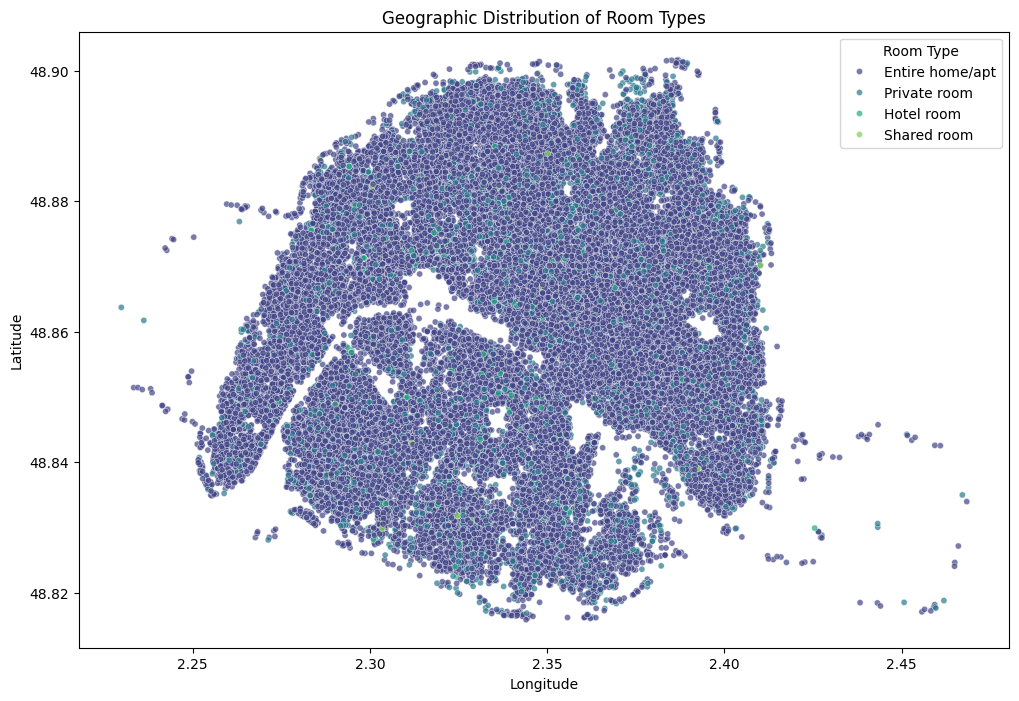

In [64]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data = listings, x = listings.longitude, y = listings.latitude, hue = listings.room_type,
    alpha=0.7,s=20, palette='viridis')
plt.title('Geographic Distribution of Room Types')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Room Type')
plt.show()

The map below reveals a clear center-periphery price gradient. Listings in the lower price ranges (0–200€, shown in blue/green) are widely distributed but become dominant as you move toward the outer arrondissements and suburbs. In contrast, higher-priced listings (red/purple/yellow/orange) are heavily clustered in the historic center (near the Louvre, Champs-Élysées, and Le Marais) and the western districts (8th, 16th arrondissements), which are traditionally more affluent areas. This aligns with Paris real estate trends where central location and proximity to major tourist landmarks drive significantly higher nightly rates

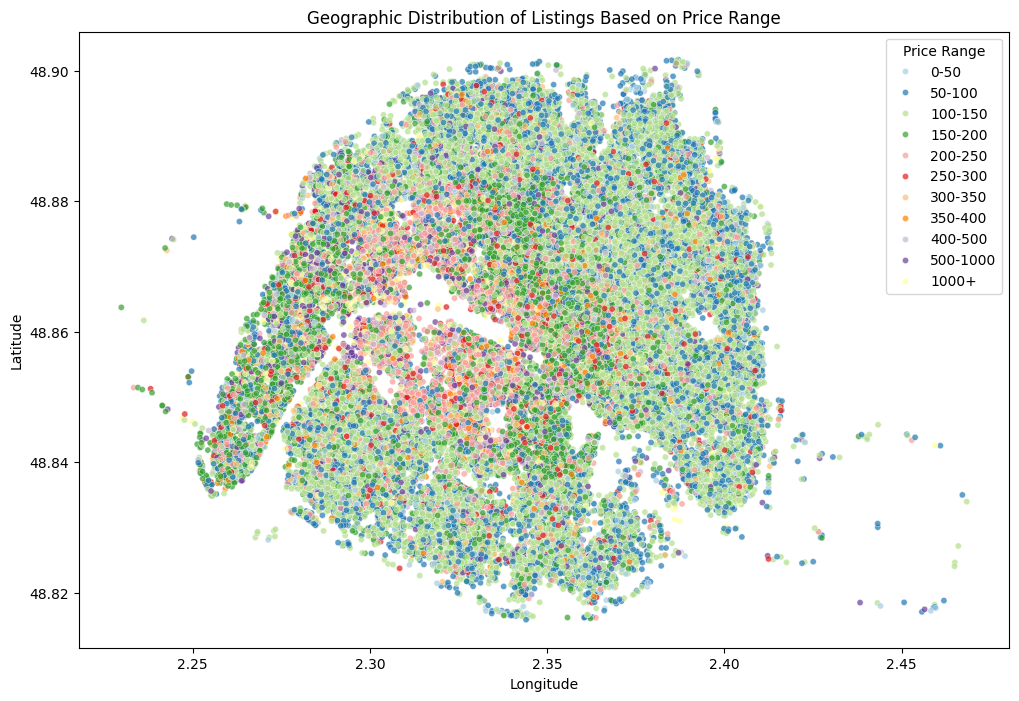

In [65]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data = listings, x = listings.longitude, y = listings.latitude, hue = listings.price_range,
    alpha=0.7,s=20, palette='Paired')
plt.title('Geographic Distribution of Listings Based on Price Range')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Price Range')
plt.show()

In [66]:
listings.corr(numeric_only = True)

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,price_calendar
id,1.000000,0.425887,-0.005490,-0.060428,0.060219,-0.379397,-0.272243,0.130405,0.105956,0.222641,0.047893,0.092123
host_id,0.425887,1.000000,-0.049763,-0.105019,0.046404,-0.177284,-0.082450,0.154373,0.115822,0.167470,0.096272,0.091022
latitude,-0.005490,-0.049763,1.000000,0.096393,-0.010832,0.004325,-0.015297,-0.015790,-0.006264,-0.007403,-0.015694,-0.005463
longitude,-0.060428,-0.105019,0.096393,1.000000,-0.074349,0.001386,0.016791,-0.002928,-0.093680,-0.065827,0.000672,-0.063082
price,0.060219,0.046404,-0.010832,-0.074349,1.000000,-0.046828,-0.031714,-0.034922,0.014861,0.118609,-0.039011,0.483405
minimum_nights,-0.379397,-0.177284,0.004325,0.001386,-0.046828,1.000000,-0.113923,-0.204666,-0.041891,-0.188555,-0.185432,-0.061760
number_of_reviews,-0.272243,-0.082450,-0.015297,0.016791,-0.031714,-0.113923,1.000000,0.595365,-0.046664,0.045472,0.625361,-0.030699
reviews_per_month,0.130405,0.154373,-0.015790,-0.002928,-0.034922,-0.204666,0.595365,1.000000,-0.027584,0.088247,0.844594,0.007458
calculated_host_listings_count,0.105956,0.115822,-0.006264,-0.093680,0.014861,-0.041891,-0.046664,-0.027584,1.000000,0.141563,-0.031337,0.026270
availability_365,0.222641,0.167470,-0.007403,-0.065827,0.118609,-0.188555,0.045472,0.088247,0.141563,1.000000,0.075511,0.089540


<Axes: >

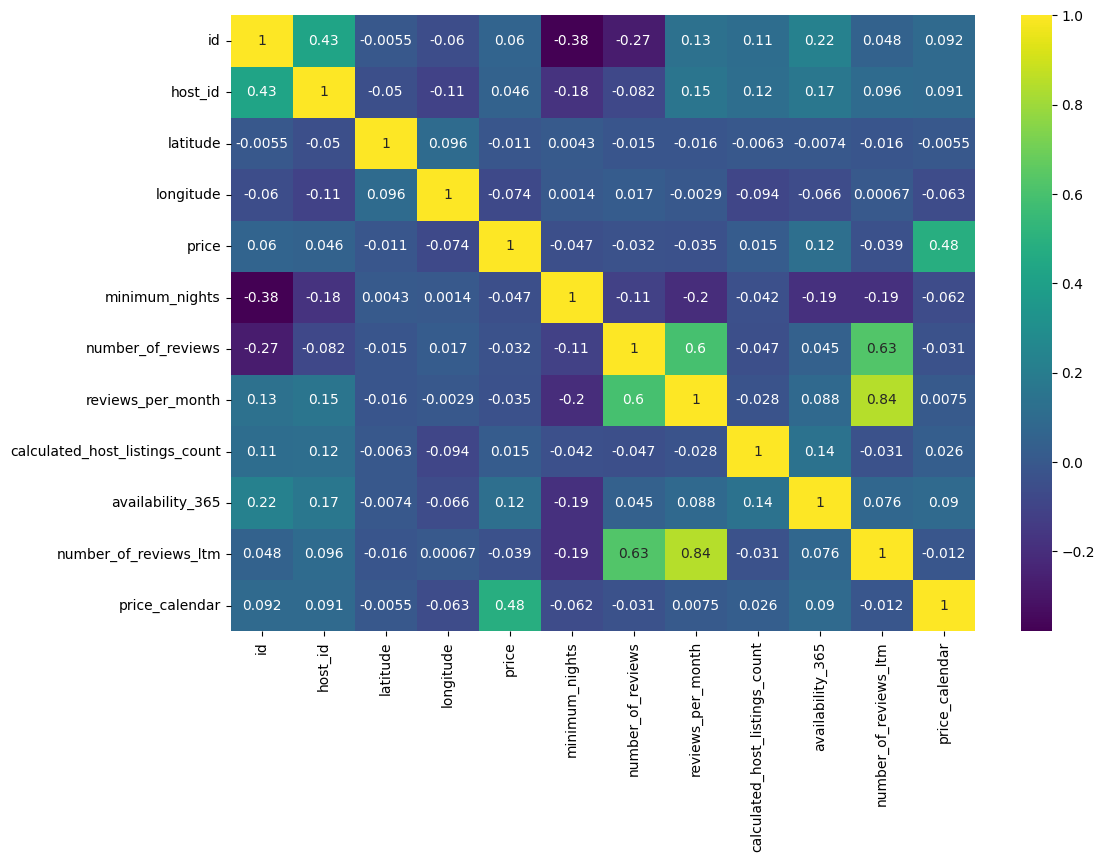

In [67]:
plt.figure(figsize=(12, 8))
sns.heatmap(listings.corr(numeric_only = True), annot = True, cmap = 'viridis')

<h1 style="color:brown;">Price Prediction Model: Preparing for Regression</h1>


In [68]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86019 entries, 0 to 86063
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   id                              86019 non-null  int64   
 1   name                            86019 non-null  object  
 2   host_id                         86019 non-null  int64   
 3   host_name                       86019 non-null  object  
 4   neighbourhood                   86019 non-null  object  
 5   latitude                        86019 non-null  float64 
 6   longitude                       86019 non-null  float64 
 7   room_type                       86019 non-null  object  
 8   price                           86019 non-null  float64 
 9   minimum_nights                  86019 non-null  int64   
 10  number_of_reviews               86019 non-null  int64   
 11  reviews_per_month               86019 non-null  float64 
 12  calculated_host_listing

In [69]:
listings.head()

,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,price_calendar,price_range
0,860812784662157555,Appartement typique Pigalle,58990604,Georges,Buttes-Montmartre,48.884650,2.336370,Entire home/apt,120.0,3,1,0.14,1,0,1,222.0,100-150
1,6124124,NEMOZ,31775536,Isabelle,Temple,48.864110,2.358860,Entire home/apt,185.0,365,0,0.00,1,0,0,70.0,150-200
2,1133277420751404475,Charmant Triplex familial du canal de Saint Ma...,245844815,Katy Et Jérémy,Entrepôt,48.871145,2.374112,Entire home/apt,140.0,1,0,0.00,97,0,0,280.0,100-150
3,33447221,Charmant appartement XVIII ème,59564639,Julien,Buttes-Montmartre,48.892810,2.360890,Entire home/apt,120.0,365,12,0.17,1,0,0,30.0,100-150
4,1209528090558606725,Personalized Studio,224340855,Shivam,Batignolles-Monceau,48.881473,2.280848,Private room,110.0,1,0,0.00,1,3,0,110.0,100-150


<h4 style="color:pink;">Lets remove the unwanted features</h4>
<h4 style="color:pink;">for example we might want to remove the id column, the name of the listing,host_id and host_name</h4>


In [70]:
listings.drop(labels = ['id', 'name', 'host_id', 'host_name','price_range'],axis = 1, inplace=True)

In [71]:
listings.head()

,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,price_calendar
0,Buttes-Montmartre,48.884650,2.336370,Entire home/apt,120.0,3,1,0.14,1,0,1,222.0
1,Temple,48.864110,2.358860,Entire home/apt,185.0,365,0,0.00,1,0,0,70.0
2,Entrepôt,48.871145,2.374112,Entire home/apt,140.0,1,0,0.00,97,0,0,280.0
3,Buttes-Montmartre,48.892810,2.360890,Entire home/apt,120.0,365,12,0.17,1,0,0,30.0
4,Batignolles-Monceau,48.881473,2.280848,Private room,110.0,1,0,0.00,1,3,0,110.0


In [72]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86019 entries, 0 to 86063
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood                   86019 non-null  object 
 1   latitude                        86019 non-null  float64
 2   longitude                       86019 non-null  float64
 3   room_type                       86019 non-null  object 
 4   price                           86019 non-null  float64
 5   minimum_nights                  86019 non-null  int64  
 6   number_of_reviews               86019 non-null  int64  
 7   reviews_per_month               86019 non-null  float64
 8   calculated_host_listings_count  86019 non-null  int64  
 9   availability_365                86019 non-null  int64  
 10  number_of_reviews_ltm           86019 non-null  int64  
 11  price_calendar                  86019 non-null  float64
dtypes: float64(5), int64(5), object(2)
me

In [73]:
listings_cleaned = listings.copy()


<h4 style="color:pink;">Before encoding, we can see that the price column contains extreme outliers</h4>
<h4 style="color:pink;">In our violin plot below we can see that most of our data is clustered below the 300-250 price range, and a long thin tail goes up to 30,000 price range. This suggest the presence of extreme outliers in the price column. Also we can support our finding when using the .describe() command; 75% of our data is 200.0 or less, yet the maximum price is set to 30,400. Finally we can see for the second violin plot that when we filter our data by removing the top 1%, the outliers are eliminated</h4>
<h4 style="color:red;">So what we will do is remove the top 1% from our data (considered as outliers) and only take price values that are less or equal to 250</h4>

<Axes: ylabel='price'>

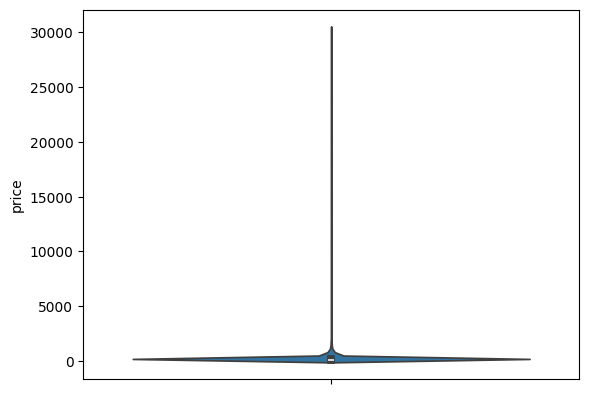

In [74]:
sns.violinplot(data = listings.price)

In [75]:
listings['price'].describe()

count    86019.000000
mean       212.513805
std        493.947276
min          8.000000
25%        106.000000
50%        140.000000
75%        198.000000
max      30400.000000
Name: price, dtype: float64

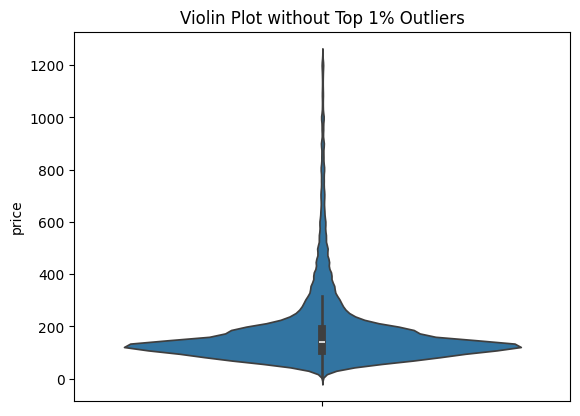

In [84]:
threshold = listings['price'].quantile(0.99)
filtered = listings[listings['price'] <= threshold]

sns.violinplot(y=filtered['price'])
plt.title("Violin Plot without Top 1% Outliers")
plt.show()


In [77]:
price_threshold = listings_cleaned['price'].quantile(0.99)

In [78]:
listings_cleaned = listings_cleaned[listings_cleaned['price'] <= price_threshold]

In [79]:
listings_cleaned = listings_cleaned.reset_index(drop=True)

In [61]:
listings_cleaned=listings_cleaned[listings_cleaned['price'] <=250]

In [62]:
listings_cleaned.price.describe()

count    72624.000000
mean       133.250744
std         46.576502
min          8.000000
25%        100.000000
50%        130.000000
75%        167.000000
max        250.000000
Name: price, dtype: float64

In [63]:
listings_cleaned.isnull().sum()

neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
number_of_reviews_ltm             0
price_calendar                    0
dtype: int64

<h4 style="color:pink;">Now we can start encoding to convert categorical data (features)</h4>

In [64]:
listings_encoded = pd.get_dummies(listings_cleaned, columns=['neighbourhood', 'room_type'], drop_first=True).astype(int)

In [65]:
listings_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72624 entries, 0 to 85157
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype
---  ------                           --------------  -----
 0   latitude                         72624 non-null  int64
 1   longitude                        72624 non-null  int64
 2   price                            72624 non-null  int64
 3   minimum_nights                   72624 non-null  int64
 4   number_of_reviews                72624 non-null  int64
 5   reviews_per_month                72624 non-null  int64
 6   calculated_host_listings_count   72624 non-null  int64
 7   availability_365                 72624 non-null  int64
 8   number_of_reviews_ltm            72624 non-null  int64
 9   price_calendar                   72624 non-null  int64
 10  neighbourhood_Bourse             72624 non-null  int64
 11  neighbourhood_Buttes-Chaumont    72624 non-null  int64
 12  neighbourhood_Buttes-Montmartre  72624 non-null  in

In [66]:
X = listings_encoded.drop('price', axis=1)
Y = listings_encoded['price']


In [67]:
X

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,price_calendar,neighbourhood_Bourse,...,neighbourhood_Panthéon,neighbourhood_Passy,neighbourhood_Popincourt,neighbourhood_Reuilly,neighbourhood_Temple,neighbourhood_Vaugirard,neighbourhood_Élysée,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,48,2,4,31,1,1,318,13,165,0,...,0,0,0,0,1,0,0,0,0,0
1,48,2,7,2,0,1,0,0,200,0,...,0,0,0,0,0,0,1,0,0,0
2,48,2,2,7,0,11,62,7,110,0,...,0,0,0,0,0,0,0,0,0,0
3,48,2,3,55,1,1,0,14,88,0,...,0,0,1,0,0,0,0,0,0,0
4,48,2,2,2,0,1,0,2,240,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85153,48,2,3,2,0,1,231,2,119,0,...,0,0,0,0,0,0,0,0,0,0
85154,48,2,5,84,2,3,20,33,100,0,...,1,0,0,0,0,0,0,0,1,0
85155,48,2,10,43,0,1,0,2,65,0,...,0,0,0,0,0,0,0,0,0,0
85156,48,2,30,4,0,1,0,0,100,0,...,0,0,0,0,0,0,1,0,0,0


In [68]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72624 entries, 0 to 85157
Data columns (total 31 columns):
 #   Column                           Non-Null Count  Dtype
---  ------                           --------------  -----
 0   latitude                         72624 non-null  int64
 1   longitude                        72624 non-null  int64
 2   minimum_nights                   72624 non-null  int64
 3   number_of_reviews                72624 non-null  int64
 4   reviews_per_month                72624 non-null  int64
 5   calculated_host_listings_count   72624 non-null  int64
 6   availability_365                 72624 non-null  int64
 7   number_of_reviews_ltm            72624 non-null  int64
 8   price_calendar                   72624 non-null  int64
 9   neighbourhood_Bourse             72624 non-null  int64
 10  neighbourhood_Buttes-Chaumont    72624 non-null  int64
 11  neighbourhood_Buttes-Montmartre  72624 non-null  int64
 12  neighbourhood_Entrepôt           72624 non-null  in

# Airbnb Price Prediction – Model Training

In this section, we build machine learning models to predict the price of Airbnb listings in Paris using structured tabular data. 

We begin by defining our features (X) and target variable (y), then we split the data into training and testing sets. We train several regression models, starting with simple baselines and then using state-of-the-art ensemble methods such as Random Forest, XGBoost, LightGBM, and CatBoost, which are known to perform exceptionally well on tabular datasets.

The goal is to compare model performance in order to identify the most accurate method for predicting listing prices.


In [69]:
from sklearn.model_selection import train_test_split

X = listings_encoded.drop(['price'], axis=1)
y = listings_encoded['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Baseline Models

We first train simple baseline models to understand the difficulty of the prediction task. These models serve as reference points before using more powerful ensemble models.

Models included:
- Linear Regression
- Ridge / Lasso Regression
- k-Nearest Neighbors Regressor


In [70]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate(model, X_test, y_test):
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = mean_squared_error(y_test, preds) ** 0.5
    return mae, rmse


In [71]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor

param_grids = {
    "Linear Regression": {
        "fit_intercept": [True, False]
    },

    "Ridge": {
        "alpha": [0.1, 1, 10, 50]
    },

    "Lasso": {
        "alpha": [0.001, 0.01, 0.1, ]
    },

    "KNN": {
        "n_neighbors": [3, 5, 7,10],
        "weights": ["uniform", "distance"],
        "p": [1, 2]  
    }
}


In [72]:
base_models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "KNN": KNeighborsRegressor()
}

grid_results = {}

for name, model in base_models.items():
    print(f"\nTraining GridSearch for {name}...\n")

    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        scoring="neg_mean_absolute_error",  
        cv=3,                                
        verbose=2,                           
        n_jobs=1                            
    )

    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    mae, rmse = evaluate(best_model, X_test, y_test)

    grid_results[name] = {
        "best_params": grid.best_params_,
        "test_mae": mae,
        "test_rmse": rmse
    }


Training GridSearch for Linear Regression...

Fitting 3 folds for each of 2 candidates, totalling 6 fits
ERROR! Session/line number was not unique in database. History logging moved to new session 267
[CV] END .................................fit_intercept=True; total time=   0.0s
[CV] END .................................fit_intercept=True; total time=   0.0s
[CV] END .................................fit_intercept=True; total time=   0.0s
[CV] END ................................fit_intercept=False; total time=   0.0s
[CV] END ................................fit_intercept=False; total time=   0.0s
[CV] END ................................fit_intercept=False; total time=   0.0s

Training GridSearch for Ridge...

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alph

the result for base line models as we said above with random selection of hyperparameters, since in the next part we will use gridsearch for chosing the right parameters

In [73]:
grid_results

{'Linear Regression': {'best_params': {'fit_intercept': True},
  'test_mae': 28.24948134872837,
  'test_rmse': 40.19224623796577},
 'Ridge': {'best_params': {'alpha': 0.1},
  'test_mae': 28.24958826619086,
  'test_rmse': 40.19223370603719},
 'Lasso': {'best_params': {'alpha': 0.001},
  'test_mae': 28.25327493586421,
  'test_rmse': 40.19213416158308},
 'KNN': {'best_params': {'n_neighbors': 10, 'p': 1, 'weights': 'distance'},
  'test_mae': 21.344502749854616,
  'test_rmse': 30.223709480488118}}

## Ensemble Models (Best Performance)

These models are known to perform extremely well on structured tabular data which is for our case that is listings data:

- Random Forest Regressor
- Extra Trees Regressor
- XGBoost Regressor (gradient boosting)
- LightGBM Regressor (gradient boosting)
- CatBoost Regressor (handles categorical features very well)

We train these models and evaluate them using MAE and RMSE.


# from here I did use my computer GPU so its faster it might not run in your computer
Here we did used more performant models for tabular data boosting models

In [74]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

def evaluate(model, X_test, y_test):
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    return mae, rmse


big_models = {
    "Random Forest": RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1),
    "Extra Trees": ExtraTreesRegressor(n_estimators=300, random_state=42, n_jobs=-1)
}

# GPU XGBoost
from xgboost import XGBRegressor
big_models["XGBoost"] = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    tree_method="hist",        
    predictor="gpu_predictor",    
    random_state=42,
    verbosity=1
)

# GPU LightGBM
from lightgbm import LGBMRegressor
big_models["LightGBM"] = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    device="gpu",                 
    random_state=42,
    verbose=1
)

# GPU CatBoost
from catboost import CatBoostRegressor
big_models["CatBoost"] = CatBoostRegressor(
    iterations=500,
    learning_rate=0.05,
    depth=8,
    task_type="GPU",              
    verbose=50,
    random_state=42
)



big_results = {}

for name, model in big_models.items():
    print(f"\n Training {name}...", flush=True)
    model.fit(X_train, y_train)
    big_results[name] = evaluate(model, X_test, y_test)
    print(f" {name} Done. MAE: {big_results[name][0]:.2f}, RMSE: {big_results[name][1]:.2f}", flush=True)

# Show results
print("\n=== Ensemble Models Results ===")
for name, metrics in big_results.items():
    print(f"{name}: MAE = {metrics[0]:.2f}, RMSE = {metrics[1]:.2f}")



 Training Random Forest...
 Random Forest Done. MAE: 15.01, RMSE: 24.75

 Training Extra Trees...
 Extra Trees Done. MAE: 15.79, RMSE: 25.63

 Training XGBoost...
 XGBoost Done. MAE: 14.81, RMSE: 23.89

 Training LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1079
[LightGBM] [Info] Number of data points in the train set: 58099, number of used features: 29
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 5070 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 7 dense feature groups (0.44 MB) transferred to GPU in 0.001069 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 133.416496
 LightGBM Done. MAE: 15.41, RMSE: 24.18

 Training CatBoost...
0:	learn: 45.5001258	total: 205ms	remai

Now we perform a comprehensive Grid Search to optimize five different tree-based regression models: Random Forest, Extra Trees, XGBoost, LightGBM, and CatBoost.

In [76]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

param_grid = {
    "Random Forest": {
        "n_estimators": [200, 300],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2]
    },
    "Extra Trees": {
        "n_estimators": [200, 300],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2]
    },
    "XGBoost": {
        "n_estimators": [200, 500],
        "max_depth": [6, 8, 10],
        "learning_rate": [0.01, 0.05, 0.1]
    },
    "LightGBM": {
        "n_estimators": [200, 500],
        "max_depth": [6, 8, 10],
        "learning_rate": [0.01, 0.05, 0.1]
    },
    "CatBoost": {
        "iterations": [200, 500],
        "depth": [6, 8, 10],
        "learning_rate": [0.01, 0.05, 0.1]
    }
}

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

models = {
    "Random Forest": RandomForestRegressor(random_state=42, n_jobs=-1),
    "Extra Trees": ExtraTreesRegressor(random_state=42, n_jobs=-1),
    "XGBoost": XGBRegressor(tree_method="hist", predictor="gpu_predictor", random_state=42, verbosity=1),
    "LightGBM": LGBMRegressor(device="gpu", random_state=42, verbose=-1),
    "CatBoost": CatBoostRegressor(task_type="GPU", verbose=50, random_state=42)
}

best_models = {}

for name, model in models.items():
    print(f"\n Grid Search for {name}...")
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid[name],
        scoring=mae_scorer,
        cv=3,
        verbose=1,
        n_jobs=1
    )
    gs.fit(X_train, y_train)
    best_models[name] = gs.best_estimator_
    print(f" Best parameters for {name}: {gs.best_params_}")
    preds = best_models[name].predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(np.mean((y_test - preds) ** 2))
    print(f"{name}: MAE = {mae:.2f}, RMSE = {rmse:.2f}")


 Grid Search for Random Forest...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
 Best parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Random Forest: MAE = 14.89, RMSE = 24.53

 Grid Search for Extra Trees...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
 Best parameters for Extra Trees: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Extra Trees: MAE = 15.63, RMSE = 25.21

 Grid Search for XGBoost...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
 Best parameters for XGBoost: {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 200}
XGBoost: MAE = 14.77, RMSE = 23.92

 Grid Search for LightGBM...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
 Best parameters for LightGBM: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 500}
LightGBM: MAE = 15.15, RMSE = 24.00

 Grid Search for CatBoost...
Fitting 3 folds for

The Grid Search results highlight the superior performance of gradient boosting methods over standard bagging ensembles for this pricing task. So it did help us get the best hyperparameters

XGBoost achieved the lowest error (MAE = 14.77), narrowly outperforming CatBoost (14.88) and Random Forest (14.89). This suggests that the gradient boosting approach effectively captured complex non-linear patterns in the data

 On average, our model's price prediction is off by about €15. Given that many listings are priced between €100-300, this represents a reasonably strong predictive accuracy.

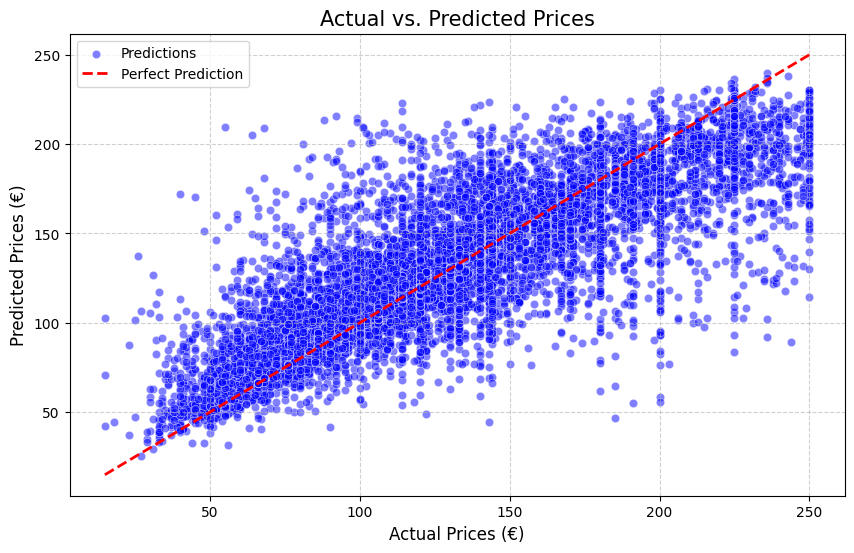

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

preds = best_models["XGBoost"].predict(X_test)  

# 2. Create the plot
plt.figure(figsize=(10, 6))

sns.scatterplot(x=y_test, y=preds, alpha=0.5, color='blue', label='Predictions')

min_val = min(y_test.min(), preds.min())
max_val = max(y_test.max(), preds.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label='Perfect Prediction')

plt.title('Actual vs. Predicted Prices', fontsize=15)
plt.xlabel('Actual Prices (€)', fontsize=12)
plt.ylabel('Predicted Prices (€)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()


In [80]:
def evaluate(model, X_test, y_test):
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    return mae, rmse

base_models = [
    ('rf', RandomForestRegressor(n_estimators=300, max_depth=None,
                                 min_samples_leaf=2, min_samples_split=5,
                                 n_jobs=-1, random_state=42)),
    
    ('et', ExtraTreesRegressor(n_estimators=300, max_depth=None,
                               min_samples_leaf=1, min_samples_split=5,
                               n_jobs=-1, random_state=42)),
    
    ('xgb', XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=8,
                         tree_method="hist", predictor="gpu_predictor",
                         random_state=42, verbosity=0)),
    
    ('lgbm', LGBMRegressor(n_estimators=500, learning_rate=0.1, max_depth=6,
                           device='gpu', random_state=42, verbose=-1)),
    
    ('cat', CatBoostRegressor(iterations=500, depth=10, learning_rate=0.1,
                              task_type='GPU', verbose=0, random_state=42))
]

meta_model = LinearRegression(n_jobs=-1)
stack_model = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,
    n_jobs=1,       
    passthrough=True
)


print("Training Stacking Ensemble...")
stack_model.fit(X_train, y_train)
mae, rmse = evaluate(stack_model, X_test, y_test)
print(f"Stacking Ensemble Done. MAE: {mae:.2f}, RMSE: {rmse:.2f}")


⏳ Training Stacking Ensemble...
Stacking Ensemble Done. MAE: 14.60, RMSE: 23.59
